# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
from collections import Counter

import pandas as pd
import numpy as np
import sklearn
from scipy.linalg import svd
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline


import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.random_walk_defs
    reload((defs))
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root

finally:
    os.chdir(nbPath)


%run "_dataset-selection.ipynb"

['/home/jcc319/multi_animal_alignment/data/random_walk/Chewie/Chewie_RT_VR_2013-12-13.mat', '/home/jcc319/multi_animal_alignment/data/random_walk/Chewie/Chewie_RT_VR_2013-10-11.mat', '/home/jcc319/multi_animal_alignment/data/random_walk/Chewie/Chewie_RT_FF_2013-12-09.mat', '/home/jcc319/multi_animal_alignment/data/random_walk/Chewie/Chewie_RT_FF_2013-12-18.mat', '/home/jcc319/multi_animal_alignment/data/random_walk/Chewie/Chewie_RT_FF_2013-12-17.mat', '/home/jcc319/multi_animal_alignment/data/random_walk/Chewie/Chewie_RT_VR_2013-12-12.mat', '/home/jcc319/multi_animal_alignment/data/random_walk/Chewie/Chewie_RT_FF_2013-10-28.mat', '/home/jcc319/multi_animal_alignment/data/random_walk/Chewie/Chewie_RT_FF_2013-12-10.mat', '/home/jcc319/multi_animal_alignment/data/random_walk/Chewie/Chewie_RT_VR_2013-10-10.mat', '/home/jcc319/multi_animal_alignment/data/random_walk/Chewie/Chewie_RT_CS_2016-10-21.mat', '/home/jcc319/multi_animal_alignment/data/random_walk/Chewie/Chewie_RT_FF_2013-10-29.mat'

## load data

In [11]:
def get_full_random_walk_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList['MCx'].items():
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    allDFs_exec_MCx = []
    for animal, session in full_list_MCx:
        path = root/'random_walk'/animal/session
        df_ = defs.prep_general(dt.load_pyal_data(path))

        #separate into reaches
        df_ = defs.get_reaches_df(df_)
        df_['reach_id'] = range(len(df_))

        #subset center-out trials
        df_ = df_[df_.center_dist < defs.subset_radius]
        df_ = df_.reset_index()

        #execution epoch
        for col in df_.columns:  #TODO: placeholder to prevent bug in pyaldata
            if 'unit_guide' in col:
                df_ = df_.drop([col], axis = 1)
        df_ = pyal.add_movement_onset(df_)
        allDFs_MCx.append(df_)

        df_ = pyal.restrict_to_interval(df_, epoch_fun=defs.exec_epoch)
        allDFs_exec_MCx.append(df_)

        # print(len(df_))
        
    return full_list_MCx, allDFs_MCx, allDFs_exec_MCx

def get_paired_dfs():
    MCx_list, allDFs_MCx, allDFs_exec_MCx = get_full_random_walk_data()

    ref_file = 'Chewie_RT_CS_2016-10-21.mat'
    ref_i = [y for x,y in MCx_list].index(ref_file)
    df1 = allDFs_exec_MCx[ref_i]

    Mihili_files = GoodDataList['MCx']['Mihili']
    MrT_files = GoodDataList['MCx']['MrT']
    comparison_files = Mihili_files + MrT_files

    paired_dfs = []
    for ex_file in comparison_files:
        # print(ex_file)

        ex_i = [y for x,y in MCx_list].index(ex_file)
        df2 = allDFs_exec_MCx[ex_i]

        #subset dataframes with matched reaches
        df1_idx, df2_idx = defs.get_matched_reaches_idx(df1, df2)
        df1_subset = df1.iloc[df1_idx]
        df2_subset = df2.iloc[df2_idx]

        #get dataframes from whole-trial data
        df1_ = pd.DataFrame({'reach_id':df1_subset.reach_id}).merge(allDFs_MCx[ref_i])
        df2_ = pd.DataFrame({'reach_id':df2_subset.reach_id}).merge(allDFs_MCx[ex_i])

        #set target ids
        # print(len(df1_) - (df1_.target_group.values == df2_.target_group.values).sum(), 'diff target groups')
        df1_.target_group = df2_.target_group.values 
        df1_['target_id'] = df1_.target_group.values
        df2_['target_id'] = df2_.target_group.values

        #only keep target groups with enough trials
        counter = Counter(df1_.target_group)
        subset_target_groups = [k for k, c in counter.items() if c >= defs.min_trials_per_target]
        df1_ = df1_[df1_.target_group.isin(subset_target_groups)]
        df2_ = df2_[df2_.target_group.isin(subset_target_groups)]
        # print(len(subset_target_groups))

        paired_dfs.append((ex_file, df1_, df2_))
    
    return paired_dfs

def get_example_df():
    paired_dfs = get_paired_dfs()
    ex_file =  defs.ex_file
    for file, session1, session2 in paired_dfs:
        if file == ex_file:
            return (session1.reset_index(drop=True), session2.reset_index(drop=True))
    raise ValueError('Example session not found!')


In [12]:
raster_example_df = get_example_df()

preprocessing

In [13]:
def plot_colored_line(ax, x, y, colors = None):
    """
    based on this:
    https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html?highlight=multicolored_line
    """
    if colors is None:
        colors = utility.get_colors(x.shape[0])

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, colors=colors)

    lc.set_array(y)
    line = ax.add_collection(lc)
    ax.set_ylim([y.min(),y.max()])
    ax.set_xlim([x.min(),x.max()])
    
    return ax

def plot_3d_colored_line(ax, x, y, z, colors = None, **kwargs):
    """
    based on this:
    https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html?highlight=multicolored_line
    """
    from mpl_toolkits.mplot3d.art3d import Line3DCollection
    
    if colors is None:
        colors = utility.get_colors(x.shape[0])

    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = Line3DCollection(segments, colors=colors, **kwargs)

    lc.set_array(z)
    line = ax.add_collection(lc)
    ax.set_ylim([y.min(),y.max()])
    ax.set_xlim([x.min(),x.max()])
    ax.set_zlim([z.min(),z.max()])
    
    return ax

## Plot FR rasters

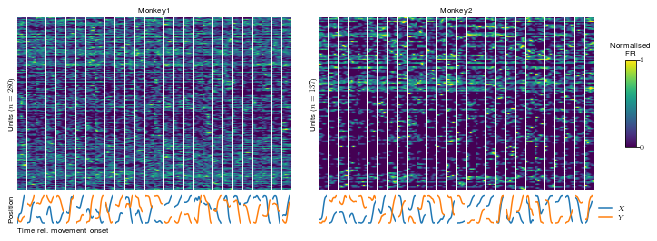

In [14]:
fig = plt.figure(figsize=(10,6))
gs1   =fig.add_gridspec(nrows=1, ncols=len(np.unique(raster_example_df[0].target_id)), left=0.1, bottom=0.4, right=.48, top=.8)
gs2   =fig.add_gridspec(nrows=1, ncols=len(np.unique(raster_example_df[1].target_id)), left=.52, bottom=0.4, right=.9, top=.8)
gs = [gs1,gs2]
gs_c = fig.add_gridspec(nrows=1, ncols=1, left=.945, bottom=0.5, right=.96, top=.7)
cax = fig.add_subplot(gs_c[:])

trial=2

for i,df in enumerate(raster_example_df):
    df2 = pyal.restrict_to_interval(df, epoch_fun=defs.exec_epoch)
    data = []
    axes = []
    for tar in np.unique(df.target_id):
        df_ = pyal.select_trials(df2, df2.target_id==tar)
        data.append(df_.MCx_rates[trial])
    data = np.array(data)
    vmin = np.amin(data, axis= (0,1))
    vmax = np.amax(data, axis= (0,1))

    for j,tarData in enumerate(data):
        ax = fig.add_subplot(gs[i][j])
        axes.append(ax)
        tarData -= vmin
        tarData /= (vmax - vmin)
        ax.imshow(tarData.T, aspect='auto')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

    axes[0].set_ylabel(f'Units ($n={data.shape[2]}$)')
fig.colorbar(cm.ScalarMappable(),cax=cax, ticks=(0,1),drawedges=False)
cax.set_title('Normalised\nFR')
ax = utility.phantom_axes(fig.add_subplot(gs1[:]))
ax.set_title('Monkey1')
ax = utility.phantom_axes(fig.add_subplot(gs2[:]))
ax.set_title('Monkey2')

#========================
gs1   =fig.add_gridspec(nrows=1, ncols=len(np.unique(raster_example_df[0].target_id)), left=0.1, bottom=0.32, right=.48, top=.39)
gs2   =fig.add_gridspec(nrows=1, ncols=len(np.unique(raster_example_df[1].target_id)), left=.52, bottom=0.32, right=.9, top=.39)
gs = [gs1,gs2]

axes = []
for i,df in enumerate(raster_example_df):
    for tar_j, tar in enumerate(np.unique(df.target_id)):
        df_ = pyal.select_trials(df, df.target_id==tar)
        data = df_.pos[trial]
        ax = fig.add_subplot(gs[i][tar_j])
        axes.append(ax)
        ax.plot(data[:,0], label='$X$')
        ax.plot(data[:,1], label='$Y$')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)

axes[0].set_ylabel('Position')
axes[-1].legend(frameon=False, loc=(1.5,0.04))
axes[0].set_xlabel('Time rel. movement onset',loc='left')

fig.savefig(params.figPath / 'RW-FR-example.pdf', format='pdf', bbox_inches='tight')

In [18]:
raster_example_df[0].head()

,reach_id,index,monkey,date,task,target_center,trial_id,result,bin_size,perturbation,...,center_id,center,pos_centered,target_centered,target_angle,angle_group,target_group,vel_norm,idx_movement_on,target_id
0,248,62,Chewie,10-21-2016,RT,"[-6.168570041656494, 2.4132485389709473]",82,R,0.03,CS,...,4,"[0.0, 0.0]","[[0.0, 0.0], [0.0684155825056566, -0.115160619...","[-5.303597381000267, 0.8912814791529229]",158.633725,2,4_2,"[5.372379498108908, 3.6374784914060303, 2.4893...",10.0,4_2
1,35,8,Chewie,10-21-2016,RT,"[-7.083327293395996, 4.992971420288086]",10,R,0.03,CS,...,10,"[-3.25, 3.25]","[[-3.25, 3.25], [-3.2589324543853904, 3.270797...","[-9.003492353455647, 4.6643557007568255]",155.549233,2,10_2,"[0.5934103291571439, 1.0181719391968678, 2.134...",1.0,10_2
2,1078,269,Chewie,10-21-2016,RT,"[-2.6474738121032715, -4.143747329711914]",366,R,0.03,CS,...,4,"[0.0, 0.0]","[[0.0, 0.0], [-0.20458880919697953, 0.20613506...","[-3.8362764887641747, -5.585241648571959]",237.425160,3,4_3,"[11.049676126044218, 8.568237462737493, 6.2817...",4.0,4_3
3,553,138,Chewie,10-21-2016,RT,"[-0.8533111214637756, -5.782141208648682]",185,R,0.03,CS,...,4,"[0.0, 0.0]","[[0.0, 0.0], [0.00039029071000840077, 0.066021...","[-0.10845016587990841, -7.369442576673112]",261.605055,4,4_4,"[2.699864683878412, 1.966317591777093, 2.69970...",11.0,4_4
4,136,34,Chewie,10-21-2016,RT,"[-4.904499053955078, 6.495218276977539]",40,R,0.03,CS,...,4,"[0.0, 0.0]","[[0.0, 0.0], [-0.029444233362661887, 0.0466902...","[-3.3422261987974826, 7.187139004758404]",127.056228,2,4_1,"[1.543995034990016, 2.0286556336868102, 2.0134...",13.0,4_1


## plot 3D trajectories, single trial per target

KeyError: 4

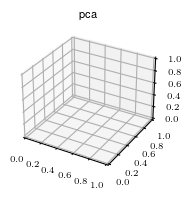

In [20]:
fig = plt.figure(figsize=(10,3), dpi=100)
gs1   =fig.add_gridspec(nrows=1, ncols=2, left=0.1, bottom=0.4, right=.48, top=.9)
gs2   =fig.add_gridspec(nrows=1, ncols=2, left=.52, bottom=0.4, right=.9, top=.9)
gs = [gs1,gs2]
# gs_c = fig.add_gridspec(nrows=1, ncols=1, left=.94, bottom=0.55, right=.96, top=.7)
# cax = fig.add_subplot(gs_c[:])
colors = utility.get_colors(8)
trial=4
dfs=[]
for i,df in enumerate(raster_example_df):
    rates = np.concatenate(df['M1_rates'].values, axis=0)
    rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
    df_ = pyal.apply_dim_reduce_model(df, rates_model, 'M1_rates', '_pca');
    dfs.append(df_)
    ax = fig.add_subplot(gs[0][i], projection='3d',fc='None')
    ax.set_title('pca')
    axes.append(ax)
    for tar in range(8):
        df__ = pyal.select_trials(df_, df_.target_id==tar)
        ex = df__._pca[trial][:,:3]
        ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
        ax.set_xticklabels([])          # removes the ticks... great now the rest of it
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.view_init(60,-47)

AllData = dt.get_data_array(raster_example_df, area='M1', model=10)
data1 = np.reshape(AllData[0,...], (-1,10))
data2 = np.reshape(AllData[1,...], (-1,10))
A,B,*_ = dt.canoncorr(data1,data2,fullReturn=True)
coef_ = [A,B]
for i,sessionData in enumerate(AllData):
    ax = fig.add_subplot(gs[1][i], projection='3d',fc='None')
    ax.set_title('cca')
    axes.append(ax)
    for tar in range(8):
        ex = sessionData[tar,trial,...]
        ex = ex @ coef_[i]
        ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
        ax.set_xticklabels([])          # removes the ticks... great now the rest of it
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.view_init(60,-47)


the above plotting of a single trial to each target does not show higher correlations as I had hoped

---

## plot 3D trajectories, target averaged

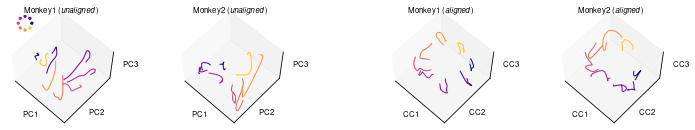

In [93]:
fig = plt.figure(figsize=(12,3))
gs1   =fig.add_gridspec(nrows=1, ncols=2, left=0.1, bottom=0.4, right=.46, top=.9)
gs2   =fig.add_gridspec(nrows=1, ncols=2, left=.54, bottom=0.4, right=.9, top=.9)
gs = [gs1,gs2]
gs_c = fig.add_gridspec(nrows=1, ncols=1, left=.13, bottom=0.82, right=.15, top=.9, wspace=0, hspace=0)
cax = fig.add_subplot(gs_c[0],zorder=10)

colors = utility.get_colors(8)
dfs=[]
axes=[]
for i,df in enumerate(raster_example_df):
    rates = np.concatenate(df['M1_rates'].values, axis=0)
    rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
    df_ = pyal.apply_dim_reduce_model(df, rates_model, 'M1_rates', '_pca');
    dfs.append(df_)
    ax = fig.add_subplot(gs[0][i], projection='3d',fc='None')
    ax.set_title('pca')
    axes.append(ax)
    for tar in range(8):
        df__ = pyal.select_trials(df_, df_.target_id==tar)
        ex = pyal.get_sig_by_trial(df__,'_pca')
        ex = np.mean(ex, axis=2)[:,:3]
        ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
        ax.view_init(60,-47)

AllData = dt.get_data_array(raster_example_df, area='M1', model=10)
data1 = np.reshape(AllData[0,...], (-1,10))
data2 = np.reshape(AllData[1,...], (-1,10))
A,B,*_ = dt.canoncorr(data1,data2,fullReturn=True)
coef_ = [A,B]
for i,sessionData in enumerate(AllData):
    ax = fig.add_subplot(gs[1][i], projection='3d',fc='None')
    ax.set_title('cca')
    U, s, Vh = svd(coef_[i], full_matrices=False, compute_uv=True, overwrite_a=False, check_finite=False)
    axes.append(ax)
    for tar in range(8):
        ex = np.mean(sessionData[tar,...], axis=0)
        ex = ex @ U @ Vh
        ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
        ax.view_init(60,-47)
        
titles=[r'Monkey1 (\textit{unaligned})',r'Monkey2 (\textit{unaligned})',
        r'Monkey1 (\textit{aligned})',  r'Monkey2 (\textit{aligned})']
labels = ['PC','PC','CC','CC']
for i, ax in enumerate(axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel(f'{labels[i]}1', labelpad=-10)
    ax.set_ylabel(f'{labels[i]}2', labelpad=-10)
    ax.set_zlabel(f'{labels[i]}3', labelpad=-10)
    ax.set_title(titles[i], pad=0, loc='center')
utility.plot_targets(cax,5)
cax.set_xlim(np.array(cax.get_xlim())*1.15)
cax.set_ylim(np.array(cax.get_ylim())*1.15)


fig.savefig(params.figPath / 'monkey-pc-example.pdf', format='pdf', bbox_inches='tight')

## Plot aligned trajectories, single trial

In [9]:
# Best M1 sessions
Bests_M1 = ('Chewie_CO_FF_2016-10-13.p', 'Jaco_CO_CS_2016-01-28.p')
BestDFs_M1 = []
for session in Bests_M1:
    path = root/session.split('_')[0]/session
    BestDFs_M1.append(prep_general(dt.load_pyal_data(path)))

ex_data = dt.get_data_array(BestDFs_M1, exec_epoch, area=areas[0], model=n_components)
n_time = ex_data.shape[-2]
n_trial = ex_data.shape[-3]

/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
/home/mostafa/Repositories/PyalData/pyaldata/tools.py:934: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


Text(0.5, 0.98, 'Across monkey alignment')

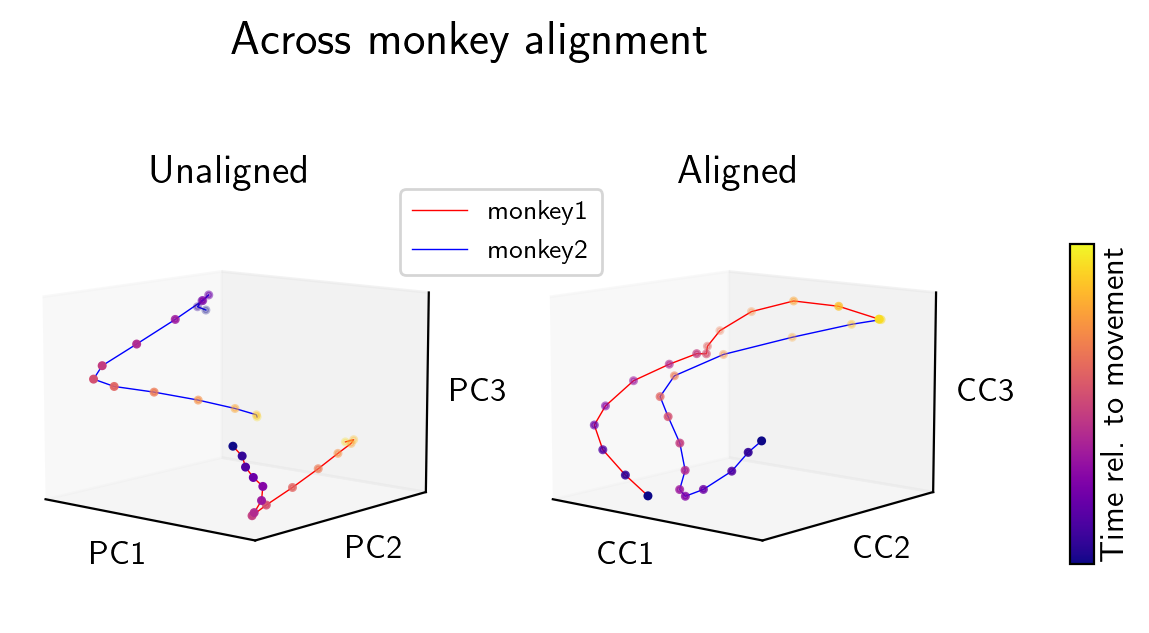

In [10]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,2,1, projection='3d',fc='None')
ax2 = fig.add_subplot(1,2,2, projection='3d',fc='None')
cax = fig.add_axes([1, 0.3, .02, 0.4])
axes = [ax,ax2]

target = 4
trial = 13

colors = utility.get_colors(n_time)
line_c=['r','b']
for i,ex in enumerate(ex_data):
    ax.scatter(ex[target,trial,:,0],ex[target,trial,:,1],ex[target,trial,:,2],
               c=colors, s=5)
    ax.plot(ex[target,trial,:,0],ex[target,trial,:,1],ex[target,trial,:,2],line_c[i],lw=.5)


data1 = np.reshape(ex_data[0,...], (-1,n_components))
data2 = np.reshape(ex_data[1,...], (-1,n_components))
*_,U,V = dt.canoncorr(data1, data2, fullReturn=True)
offset = (target*n_trial)*n_time + trial*n_time
ax2.scatter(U[offset:offset+n_time,0],U[offset:offset+n_time,1],U[offset:offset+n_time,2],
            c=colors, s=5)
l1=ax2.plot(U[offset:offset+n_time,0],U[offset:offset+n_time,1],U[offset:offset+n_time,2],
            line_c[0],lw=.5, label='monkey1')

ax2.scatter(V[offset:offset+n_time,0],V[offset:offset+n_time,1],V[offset:offset+n_time,2],
            c=colors, s=5)
l2=ax2.plot(V[offset:offset+n_time,0],V[offset:offset+n_time,1],V[offset:offset+n_time,2],
            line_c[1],lw=.5, label='monkey2')

titles=['Unaligned','Aligned']
labels = ['PC','CC']
for i, ax in enumerate(axes):
    ax.view_init(10,-50)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_xlabel(f'{labels[i]}1', labelpad=-10)
    ax.set_ylabel(f'{labels[i]}2', labelpad=-10)
    ax.set_zlabel(f'{labels[i]}3', labelpad=-10)
    ax.set_title(titles[i], pad=0)
axes[0].legend(handles=[l1[0], l2[0]],loc=(.9,.8))
fig.colorbar(cm.ScalarMappable(cmap='plasma'),cax=cax,ax=ax, label='Time rel. to movement', ticks=[])

fig.suptitle('Across monkey alignment', fontsize = 'xx-large')
